## Simple statistical analysis of behavior

* accuracy
* slope/gamma
* bias 

can be explained by IQ,age, `group` etc. ?

simple regression models to find "raw" patterns in data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import os
import pingouin as pg

bids_folder = '/Users/mrenke/data/ds-dnumrisk'
params_folder = op.join(bids_folder,'derivatives/phenotype')

sns.set_context('talk')

from utils import get_data

df= get_data(bids_folder,  include_var=['group', 'age'])
df['group'] = np.where(df['group'] == 0, 'control', 'dyscalc')
df['n1'] = df['n1'].astype(int)   
df['correct_answer_n2'] = np.where((df['n2'] > df['n1']), True, False)
df['correct'] = np.where((df['correct_answer_n2'] == df['chose_n2']), True, False)

import scipy.stats as stats
df['age_z'] = stats.zscore(df['age'])

/Users/mrenke/mambaforge/envs/behav_fit/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


number of subjects found: 66
number of subjects in dataframe: 66
Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
            52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66],
           dtype='int64', name='subject')


In [63]:
import scipy.stats as stats
import statsmodels.formula.api as smf

iq_scores = pd.read_csv(op.join(params_folder, 'iq-scores_ids2.csv')).set_index('subject')
iq_scores['mean_iq_z'] = stats.zscore(iq_scores['mean_iq'])
#iq_scores.head()

In [64]:
df_part = df.reset_index(['run','trial_nr'], drop=True)[['group','age']]
df_part =df_part.reset_index().drop_duplicates().set_index('subject')
df_part['age_z'] = stats.zscore(df_part['age'])

#df_part.head()

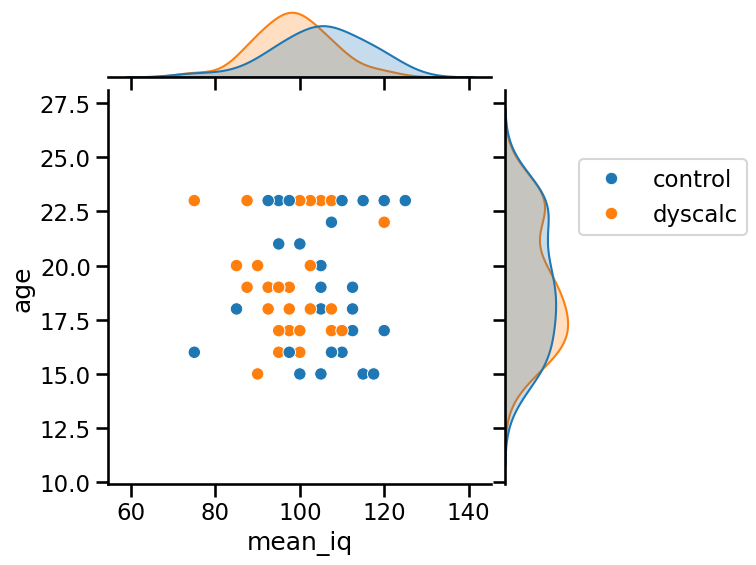

In [36]:
df_comb = df_part.join(iq_scores)
df_comb.sort_index(inplace=True)
ax = sns.jointplot(data=df_comb, x='mean_iq', y='age', hue='group')
#sns.move_legend(ax, "outside")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=3)

In [4]:
# for y ~ mean_iq_z*age_z*group

def get_ols_predictions(res):
    reg_list = [ [0,1], [-1, 1], [-1, 1]]
    names=['group', 'mean_iq_z', 'age_z']
    fake_data = pd.MultiIndex.from_product(reg_list,names=names).to_frame().reset_index(drop=True)
    fake_data['mean_iq_z:group'] = fake_data['mean_iq_z'] * fake_data['group']
    fake_data['age_z:group'] = fake_data['age_z'] * fake_data['group']
    fake_data['mean_iq_z:age_z'] = fake_data['mean_iq_z'] * fake_data['age_z'] 
    fake_data['mean_iq_z:age_z:group'] = fake_data['mean_iq_z'] * fake_data['age_z'] * fake_data['group']

    coef = res.params
    coef.index = coef.index.str.replace('\[T.dyscalc\]', '')
    coef = coef.reindex(fake_data.columns)

    prediction = (fake_data * coef).sum(axis=1) + res.params['Intercept']
    prediction.index = pd.MultiIndex.from_product(reg_list,names=names)
    prediction = prediction.to_frame(name='prediction')

    return prediction

## accuracy &/or RT
* IQ, age, group:age

In [4]:
import statsmodels.formula.api as smf

temp = df.groupby(['subject','group']).mean()

mod = smf.ols(formula='rt ~ group', data=temp.reset_index())
res = mod.fit()
#print(res.summary())

/Users/mrenke/mambaforge/envs/behav_fit/lib/python3.10/site-packages/seaborn/categorical.py:3370: UserWarning: 9.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


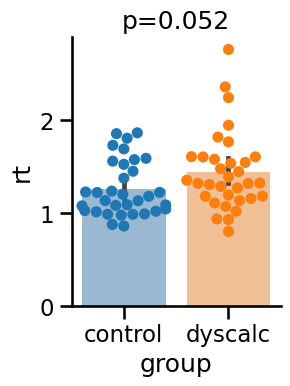

In [3]:
temp = df.groupby(['subject','group']).mean()
#temp = temp.drop([1,2,3,4,5,6,7,8,9]) # first 9 subs had different difficulty level
#temp = temp.loc[[1,2,3,4,5,6,7,8,9]]

y_var = 'rt'
an = pg.anova(data=temp.reset_index(), dv=y_var, between='group')
p_val = np.round(an['p-unc'][0],3)

fig, ax = plt.subplots(figsize=(2.7,3.5))
sns.barplot(ax=ax,data=temp.reset_index(), x='group', y=y_var, hue='group',alpha=0.5)
sns.swarmplot(ax=ax, data=temp.reset_index(), x='group', y=y_var,  hue='group',size=8)
ax.set(title=f'p={p_val}') # ylim=(0.5,1),
sns.despine()

In [11]:
def cluster_offers(d, n=6, key='frac'):
    return pd.qcut(d[key], n, duplicates='drop').apply(lambda x: np.round(x.mid,1))

df['frac_bins'] = cluster_offers(df, key='frac')

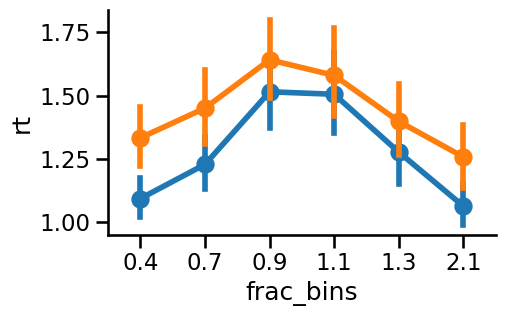

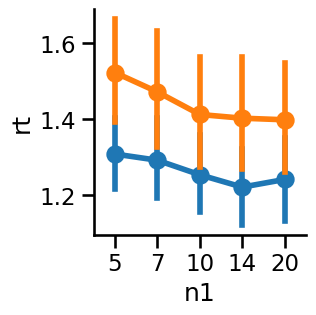

In [15]:
x_var = 'frac_bins'
tmp = df.groupby(['subject', 'group',x_var])['rt'].mean()
sns.catplot(tmp.reset_index(), y='rt', x=x_var,hue='group',errorbar='ci',kind='point',height=3.5, aspect=1.5,legend=False)

x_var = 'n1'
tmp = df.groupby(['subject', 'group',x_var])['rt'].mean()
sns.catplot(tmp.reset_index(), y='rt', x=x_var,hue='group',errorbar='ci',kind='point',height=3.5, aspect=1,legend=False)


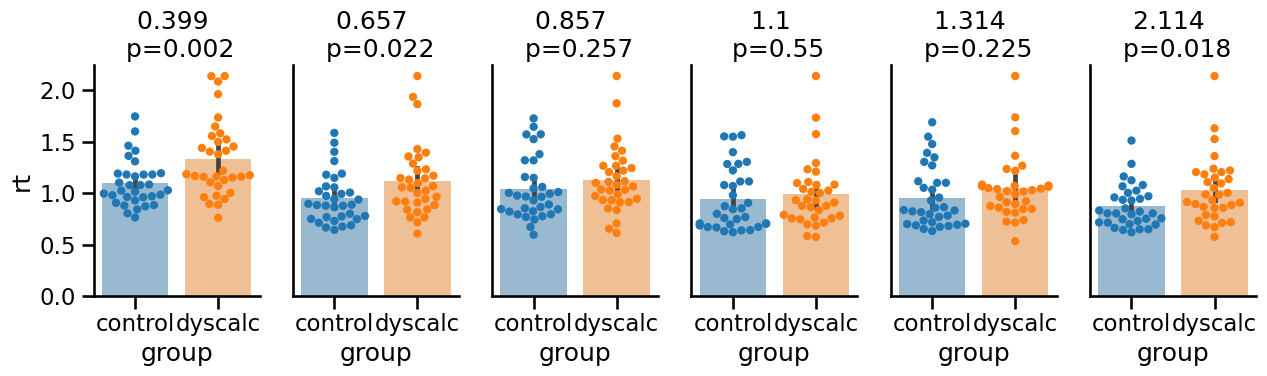

In [14]:
import pingouin as pg
import numpy as np
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='seaborn')


temp = df.groupby(['subject','group','frac_bins']).mean()
#temp = temp.drop([1,2,3,4,5,6,7,8,9])

y_var = 'rt'

frac_bin_list = temp.index.unique('frac_bins')
fig, ax = plt.subplots(1,len(frac_bin_list),figsize=(15,3.))

for i,frac_bin in enumerate(frac_bin_list):

    filtered_data = temp.xs(frac_bin,0,'frac_bins').reset_index()

    sns.barplot(ax=ax[i], data=filtered_data, x='group', hue='group', y=y_var, alpha=0.5)
    sns.swarmplot(ax=ax[i], data=filtered_data, x='group',  hue='group', y=y_var, size=6)

    # Calculate the p-value for the current frac_bins value
    an = pg.anova(data=filtered_data, dv=y_var, between='group')
    p_val = np.round(an['p-unc'][0],3)

    ax[i].set(title=f'{frac_bin} \n p={p_val}') # ylim=(0.5,1.05),
    if i != 0:
        ax[i].set(ylabel=None, yticks=[])

sns.despine()

/var/folders/3k/8g0xv78x051fznwyh_m5xcn8f91w3q/T/ipykernel_83000/3926383414.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temp = df.groupby(['subject','group','n1']).mean()


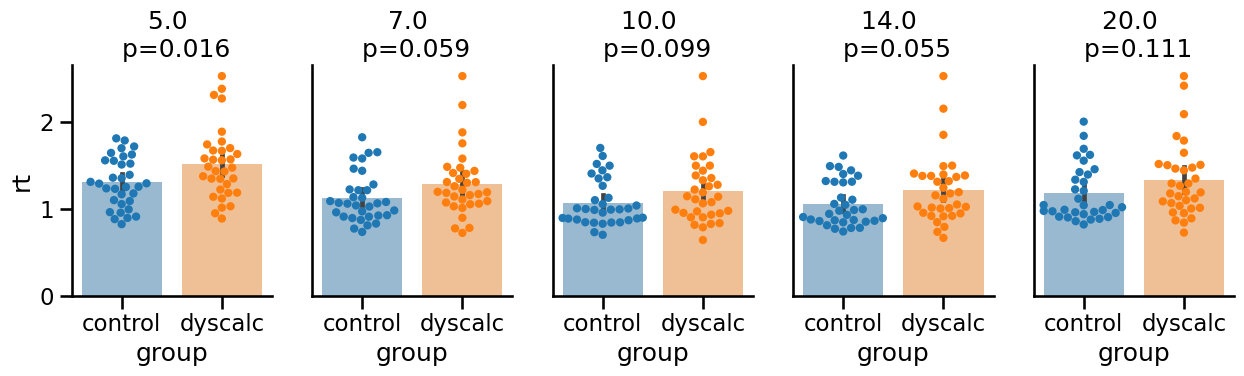

In [15]:
y_var = 'rt'

temp = df.groupby(['subject','group','n1']).mean()

n1s = temp.index.unique('n1')
fig, ax = plt.subplots(1,len(n1s),figsize=(15,3.))

for i,n1 in enumerate(n1s):

    filtered_data = temp.xs(n1,0,'n1').reset_index()

    sns.barplot(ax=ax[i], data=filtered_data, x='group', hue='group', y=y_var, alpha=0.5)
    sns.swarmplot(ax=ax[i], data=filtered_data, x='group',  hue='group', y=y_var, size=6)

    # Calculate the p-value for the current frac_bins value
    an = pg.anova(data=filtered_data, dv=y_var, between='group')
    p_val = np.round(an['p-unc'][0],3)

    ax[i].set(title=f'{n1} \n p={p_val}') # ylim=(0.5,1.05),
    if i != 0:
        ax[i].set(ylabel=None, yticks=[])

sns.despine()

In [165]:
# all: mean_iq_z*age_z*group
temp = df.groupby(['subject','group']).mean().join(iq_scores)
tmp = temp.drop([1,2,3,4,5,6,7,8,9])

mod = smf.ols(formula='correct ~ mean_iq_z*age_z*group', data=tmp.reset_index())
res = mod.fit()
print(res.summary())


                            OLS Regression Results                            
Dep. Variable:                correct   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.329
Method:                 Least Squares   F-statistic:                     4.924
Date:                Fri, 31 May 2024   Prob (F-statistic):           0.000288
Time:                        18:20:01   Log-Likelihood:                 98.508
No. Observations:                  57   AIC:                            -181.0
Df Residuals:                      49   BIC:                            -164.7
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

/var/folders/3k/8g0xv78x051fznwyh_m5xcn8f91w3q/T/ipykernel_5080/3721011728.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temp = df.groupby(['subject','group']).mean().join(iq_scores)


/var/folders/3k/8g0xv78x051fznwyh_m5xcn8f91w3q/T/ipykernel_5080/598880458.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  coef.index = coef.index.str.replace('\[T.dyscalc\]', '')


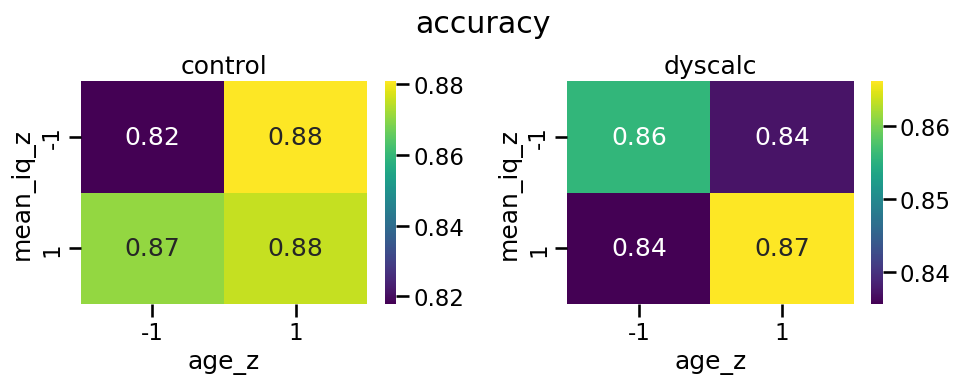

In [164]:
prediction = get_ols_predictions(res)
reshaped_data = prediction.unstack('group')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
for i, group in enumerate(reshaped_data.columns): # # Create a 2x2 heatmap for each group
    sns.heatmap(reshaped_data[group].unstack(), annot=True, fmt=".2f", cmap='viridis', ax=axes[i])
    group = 'dyscalc' if group == ('prediction', 1) else 'control'
    axes[i].set_title(f'{group}')
plt.tight_layout()
plt.suptitle('accuracy')
plt.subplots_adjust(top=0.8)
plt.show()

## Gamma
from probit model, but non hierachical to get "unbiased" subjectwise gammas

'chose_n2 ~ 0 + C(subject) + x:C(subject)'

In [155]:
gammas = pd.read_csv(op.join(params_folder, f'gamma-magjudge_probit-startSimple2.csv'))
gammas.set_index('subject', inplace=True)
gammas = gammas.join(df_part).join(iq_scores)  #, on='subject',how='left'


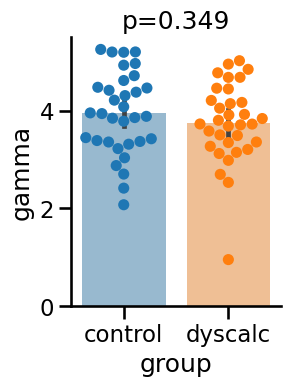

In [158]:
temp = gammas
y_var = 'gamma'
an = pg.anova(data=temp.reset_index(), dv=y_var, between='group')
p_val = np.round(an['p-unc'][0],3)

fig, ax = plt.subplots(figsize=(2.7,3.5))
sns.barplot(ax=ax,data=temp.reset_index(), x='group', y=y_var, hue='group',alpha=0.5)
sns.swarmplot(ax=ax, data=temp.reset_index(), x='group', y=y_var,  hue='group',size=8)
ax.set(title=f'p={p_val}')
sns.despine()

In [160]:
gamma_ = gamma.drop(46)
mod = smf.ols(formula='gamma ~ mean_iq_z*age_z*group', data=gamma_.reset_index()) # age_z*
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  gamma   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     1.270
Date:                Fri, 31 May 2024   Prob (F-statistic):              0.281
Time:                        17:55:16   Log-Likelihood:                -68.389
No. Observations:                  65   AIC:                             152.8
Df Residuals:                      57   BIC:                             170.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

/var/folders/3k/8g0xv78x051fznwyh_m5xcn8f91w3q/T/ipykernel_5080/598880458.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  coef.index = coef.index.str.replace('\[T.dyscalc\]', '')


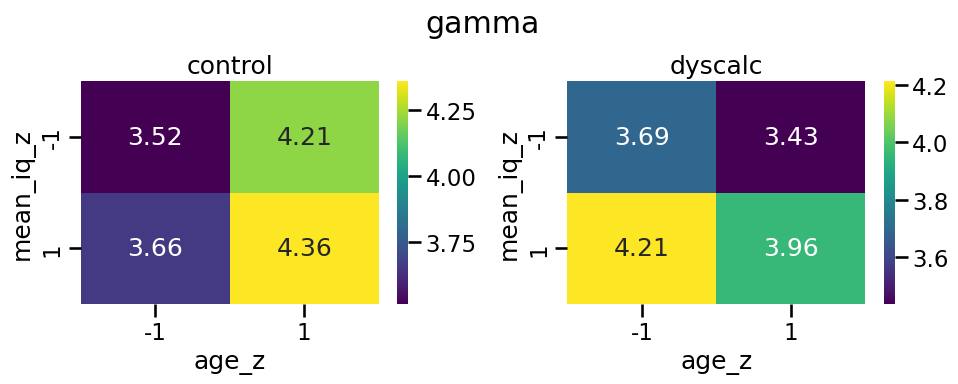

In [10]:
prediction = get_ols_predictions(res)
reshaped_data = prediction.unstack('group')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
for i, group in enumerate(reshaped_data.columns): # # Create a 2x2 heatmap for each group
    sns.heatmap(reshaped_data[group].unstack(), annot=True, fmt=".2f", cmap='viridis', ax=axes[i])
    group = 'dyscalc' if group == ('prediction', 1) else 'control'
    axes[i].set_title(f'{group}')
plt.tight_layout()
plt.suptitle('gamma')
plt.subplots_adjust(top=0.8)
plt.show()

>> for dyscalculia the age effect is reversed

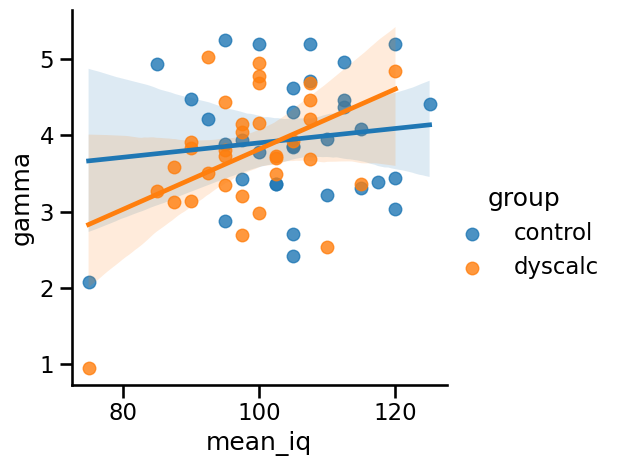

In [172]:
tmp = gamma#.drop(46)
sns.lmplot(x='mean_iq', y='gamma', hue='group', data=tmp.reset_index())

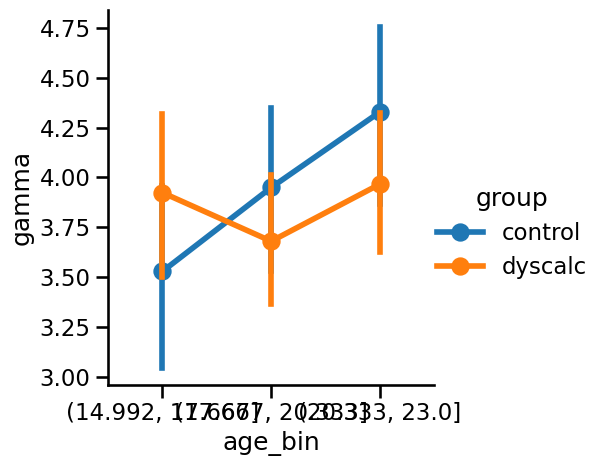

In [173]:
gammas['age_bin'] = pd.cut(gammas['age'], 3)
tmp = gammas.drop(46)
sns.catplot(x='age_bin', y='gamma', hue='group', data=tmp.reset_index(), kind='point')

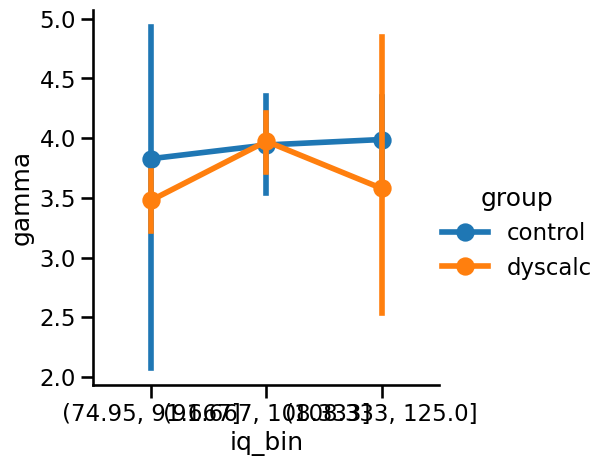

In [176]:

bins = [15, 17.5, 20, 23]
gammas['iq_bin'] = pd.cut(gammas['mean_iq'],3)

tmp = gammas.drop(46)
sns.catplot(x='iq_bin', y='gamma', hue='group', data=tmp.reset_index(), kind='point')

### subwise BIAS :prop_chosen_n2 = beta * n1

In [39]:
# 
temp = df.groupby(['subject','n1','group']).mean()
mod = smf.ols(formula='chose_n2 ~ n1*group', data=temp.reset_index())
res = mod.fit()



In [181]:
# get subwise bias for subsequent analysis

import pingouin as pg

temp = df.groupby(['subject','n1','group']).mean().reset_index()

res = temp.groupby(['subject','group']).apply(lambda x: pg.linear_regression(x['n1'], x['chose_n2']))
res = res.drop(0, level=-1)
# sns.scatterplot(data=res, x='pval', y='coef', hue='group') #relationship between coef and significance

/var/folders/3k/8g0xv78x051fznwyh_m5xcn8f91w3q/T/ipykernel_5080/2357645519.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temp = df.groupby(['subject','n1','group']).mean().reset_index()


Text(0.5, 1.0, 'p=0.06')

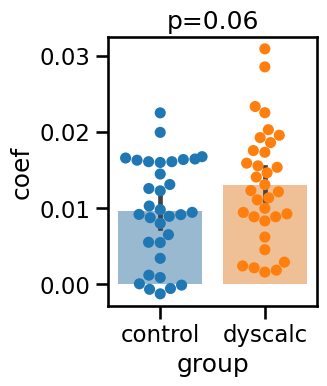

In [183]:
tmp = res['coef']

ttest = pg.ttest(tmp.xs('control', level=1), tmp.xs('dyscalc', level=1))
p_val = np.round(ttest['p-val'].values[0],3)   
y_var = 'coef'
fig, ax = plt.subplots(figsize=(2.7,3.5))
sns.barplot(ax=ax,data=tmp.reset_index(), x='group', y=y_var, hue='group',alpha=0.5)
sns.swarmplot(ax=ax, data=tmp.reset_index(), x='group', y=y_var,  hue='group',size=8)
plt.title(f'p={p_val}')

In [47]:
bias = res['coef'].to_frame().join(iq_scores).join(df_part)
bias['bias'] = bias['coef']

mod = smf.ols(formula='bias ~ age_z*mean_iq_z*group', data=bias)
res = mod.fit()

In [51]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   bias   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     1.878
Date:                Wed, 29 May 2024   Prob (F-statistic):             0.0898
Time:                        16:44:21   Log-Likelihood:                 238.82
No. Observations:                  66   AIC:                            -461.6
Df Residuals:                      58   BIC:                            -444.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

/var/folders/3k/8g0xv78x051fznwyh_m5xcn8f91w3q/T/ipykernel_5080/598880458.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  coef.index = coef.index.str.replace('\[T.dyscalc\]', '')


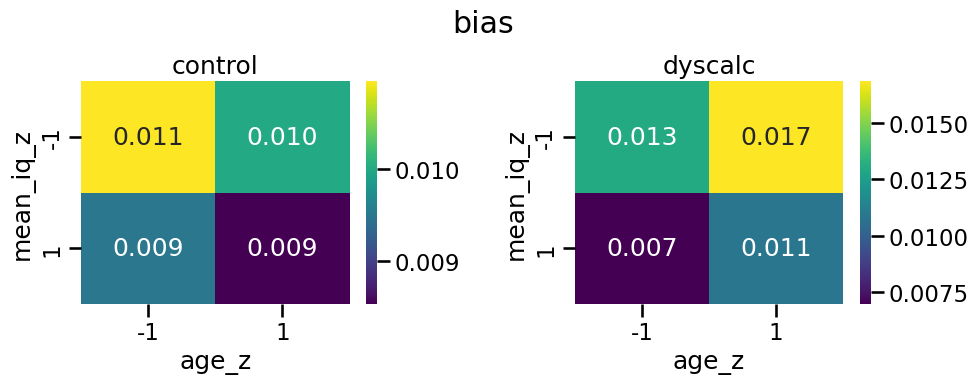

In [50]:
prediction = get_ols_predictions(res)
reshaped_data = prediction.unstack('group')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
for i, group in enumerate(reshaped_data.columns): # # Create a 2x2 heatmap for each group
    sns.heatmap(reshaped_data[group].unstack(), annot=True, fmt=".3f", cmap='viridis', ax=axes[i])
    group = 'dyscalc' if group == ('prediction', 1) else 'control'
    axes[i].set_title(f'{group}')
plt.tight_layout()
plt.suptitle('bias')
plt.subplots_adjust(top=0.8)
plt.show()

In [195]:
pd.read_csv(op.join(params_folder, 'visio-spatial-WM_CBTtask-params.csv')).set_index('subject')

,basisscore,overall_score,erfassungsspanne
subject,,,
1,5,13.0,8
2,5,10.0,6
3,4,7.0,5
4,4,7.0,6
5,4,10.0,7
...,...,...,...
62,5,10.0,6
63,6,16.0,8
64,3,11.0,7


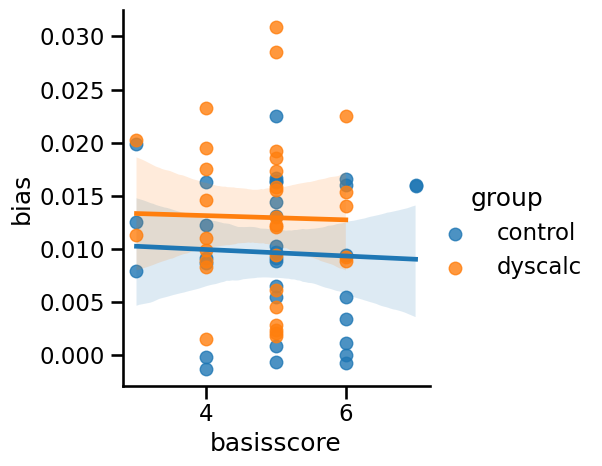

In [198]:
vs_wm = pd.read_csv(op.join(params_folder, 'visio-spatial-WM_CBTtask-params.csv')).set_index('subject')

tmp = gamma.join(bias['bias']).join(vs_wm)

sns.lmplot(tmp, x='basisscore',y='bias', hue='group')